In [181]:
import math
from sklearn.metrics import mean_squared_error
import pandas as pd
import numpy as np
import os
import re
import pickle
from bs4 import BeautifulSoup as soup
import requests as rq
import time
import h5py
import scipy as sp
import scipy.stats
import datetime
from datetime import date
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
%config InlineBackend.figure_format = 'png'
plt.rcParams['figure.dpi']= 500

# EDA

## Pulling in Data

The data collected is a mix of HDF5, csv and web scraped data about the Bay area.  The CSVs are for particle concentraions, HDF5s for CO2 ppm, and the web scraped data is for empty lot/apartments for sale in the San Fransisco.

In [2]:
#starting off by reading in the csv files
aqcsvs = []
aqcsvs += ['../../../../Documents/largecsvs/others/'+each for each in os.listdir('../../../../Documents/largecsvs/others/') if each.endswith('.csv')]

nc = []
nc += ['../../../../Documents/largecsvs/data/'+each for each in os.listdir('../../../../Documents/largecsvs/data/') if each.endswith('.nc')]

part = []
part += ['../../../../Documents/largecsvs/particle/'+each for each in os.listdir('../../../../Documents/largecsvs/particle/') if each.endswith('csv')]

In [3]:
# sorting CSVs so the are appended in order of oldest to most recent
aqcsvs=sorted(aqcsvs)
part=sorted(part)

In [4]:
#pulling in weather data from  
weatherdf = pd.read_csv('weather/1367384.csv')

In [5]:
#dropping unnecessary columns and filling NaNs
weatherdf.drop(['STATION', 'NAME','ELEVATION', 'SNWD', 'TOBS'], axis=1, inplace=True)
weatherdf = weatherdf.fillna(0)

In [6]:
weatherdf.head()

,LATITUDE,LONGITUDE,DATE,PRCP,SNOW,TAVG,TMAX,TMIN
0,37.7705,-122.4269,2014-01-01,0.0,0.0,0.0,63.0,44.0
1,37.7705,-122.4269,2014-01-02,0.0,0.0,0.0,63.0,48.0
2,37.7705,-122.4269,2014-01-03,0.0,0.0,0.0,64.0,49.0
3,37.7705,-122.4269,2014-01-04,0.0,0.0,0.0,66.0,46.0
4,37.7705,-122.4269,2014-01-05,0.0,0.0,0.0,66.0,48.0


In [7]:
nc[0]

'../../../../Documents/largecsvs/data/co2_wgc_surface-pfp_1_allvalid.nc'

In [8]:
#reading in .nc files from the file paths seen above
from netCDF4 import Dataset
inland = Dataset(nc[0])
sfco2 = Dataset(nc[1])

In [9]:
inland.dimensions.keys()

odict_keys(['obs', 'calendar_components', 'string_of_100chars'])

In [10]:
inland.variables.keys()

odict_keys(['time', 'time_decimal', 'time_components', 'solartime_components', 'value', 'latitude', 'longitude', 'altitude', 'obs_flag', 'obspack_id', 'model_enkf_flag', 'model_hqhr', 'model_r', 'model_bg', 'model_ff', 'model_ocean', 'model_bio', 'model_fires', 'assimilated', 'u', 'v', 'blh', 'q', 'temperature', 'pressure'])

In [11]:
for i in sfco2.variables.keys():
    print(i)
    print(sfco2[i][30])

time
1193652232
time_decimal
2007.8258056640625
time_components
[2007 10 29 10 3 52]
solartime_components
[-- -- -- -- -- --]
value
0.00039306998951360583
latitude
37.75
longitude
-122.44999694824219
altitude
485.8500061035156
obs_flag
0
obspack_id
[b'o' b'b' b's' b'p' b'a' b'c' b'k' b'_' b'c' b'o' b'2' b'_' b'1' b'_'
 b'G' b'L' b'O' b'B' b'A' b'L' b'V' b'I' b'E' b'W' b'p' b'l' b'u' b's'
 b'_' b'v' b'3' b'.' b'1' b'_' b'2' b'0' b'1' b'7' -- b'1' b'0' -- b'1'
 b'8' b'~' b'c' b'o' b'2' b'_' b's' b't' b'r' b'_' b's' b'u' b'r' b'f'
 b'a' b'c' b'e' -- b'p' b'f' b'p' b'_' b'1' b'_' b'a' b'l' b'l' b'v' b'a'
 b'l' b'i' b'd' b'~' b'2' b'8' b'7' b'6' b'6' b'8' -- -- -- -- -- -- -- --
 -- -- -- -- -- -- -- -- -- --]
model_enkf_flag
0
model_hqhr
0.0
model_r
--
model_bg
0.0003682364185806364
model_ff
3.420780922169797e-05
model_ocean
-7.4847644100373145e-06
model_bio
-1.8208816982223652e-05
model_fires
8.222207725339103e-06
assimilated
0
u
7.087583065032959
v
-2.201594114303589
blh
100.0
q
0.006021

In [12]:
var = inland.variables['time'].units

In [13]:
#function to pull all the CO2 data from the .nc files
def CO2df(nc):
    CO2time = []
    cc = []
    for y in np.array(nc.variables['time_components']):
        q= [str(x) for x in y]
        dt = pd.to_datetime(q[0]+', '+q[1]+', '+q[2])
        CO2time.append(dt)   
        cc.append(y)
    latlong = [(x,y) for x,y in zip(np.array(nc.variables['latitude']),np.array(nc.variables['longitude']))]
    values = [x*10**6 for x in np.array(nc.variables['value'])]
    avalues = [x*10**6 for x in np.array(nc.variables['model_bg'])]
    carbondf = pd.DataFrame({'Date':CO2time,
                             'latlong':latlong,
                             'CO2 ppm':values})
    return carbondf

In [14]:
#carbondf is the CO2 from inland california near sacramento, sfcdf is CO@ in San Fransisco 
carbondf = CO2df(inland)
sfcdf = CO2df(sfco2) 


In [15]:
sfc = sfcdf[sfcdf['Date']>pd.to_datetime('2008, 1, 1')].drop_duplicates(['Date'])
cardf = carbondf[carbondf['Date']>pd.to_datetime('2008, 1, 1')].drop_duplicates(['Date'])

In [16]:
sfc.head()

,CO2 ppm,Date,latlong
134,397.260010,2008-01-02,"(37.76, -122.45)"
135,390.620000,2008-01-03,"(37.76, -122.45)"
137,390.169997,2008-01-04,"(37.76, -122.45)"
139,388.109998,2008-01-05,"(37.76, -122.45)"
140,388.410001,2008-01-06,"(37.76, -122.45)"


In [17]:
len(cardf)

1659

In [18]:
sfc.head()

,CO2 ppm,Date,latlong
134,397.260010,2008-01-02,"(37.76, -122.45)"
135,390.620000,2008-01-03,"(37.76, -122.45)"
137,390.169997,2008-01-04,"(37.76, -122.45)"
139,388.109998,2008-01-05,"(37.76, -122.45)"
140,388.410001,2008-01-06,"(37.76, -122.45)"


In [19]:
part

['../../../../Documents/largecsvs/particle/Pdaily_88101_2008.csv',
 '../../../../Documents/largecsvs/particle/Pdaily_88101_2009.csv',
 '../../../../Documents/largecsvs/particle/Pdaily_88101_2010.csv',
 '../../../../Documents/largecsvs/particle/Pdaily_88101_2011.csv',
 '../../../../Documents/largecsvs/particle/Pdaily_88101_2012.csv',
 '../../../../Documents/largecsvs/particle/Pdaily_88101_2013.csv',
 '../../../../Documents/largecsvs/particle/Pdaily_88101_2014.csv',
 '../../../../Documents/largecsvs/particle/Pdaily_88101_2015.csv',
 '../../../../Documents/largecsvs/particle/Pdaily_88101_2016.csv',
 '../../../../Documents/largecsvs/particle/Pdaily_88101_2017.csv',
 '../../../../Documents/largecsvs/particle/Pdaily_88101_2018.csv']

In [20]:
#Reading particle data and assigning is to dataframe pdf
pdf=pd.read_csv(part[0])

for i in range(1,len(part)):
    temp = pd.read_csv(part[i])
    pdf = pd.concat([pdf,temp], ignore_index=True)

/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2728: DtypeWarning: Columns (27) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [21]:
#Filtering out unneed data from particle DF
pdf = pdf[pdf['State Name']=='California']
pdf = pdf[pdf['CBSA Name']=='San Francisco-Oakland-Hayward, CA']
pdf = pdf[pdf['City Name'].isin(['San Francisco'])]
pdf.drop(['State Code', 'County Code', 'Site Num', 'Parameter Code', 'POC', 'Datum', 'Sample Duration',
       'Pollutant Standard', 'Units of Measure', 'Event Type',
       'Observation Count', 'Observation Percent', 'AQI', 'Method Code', 'Method Name',
       'Local Site Name', 'Address', 'State Name','City Name',
       'CBSA Name', 'Date of Last Change'], axis=1, inplace=True)

pdf.reset_index(drop=True,inplace=True)

In [22]:
pdf.head()

,Latitude,Longitude,Parameter Name,Date Local,Arithmetic Mean,1st Max Value,1st Max Hour,County Name
0,37.765946,-122.399044,PM2.5 - Local Conditions,2008-01-01,19.4,19.4,0,San Francisco
1,37.765946,-122.399044,PM2.5 - Local Conditions,2008-01-02,20.4,20.4,0,San Francisco
2,37.765946,-122.399044,PM2.5 - Local Conditions,2008-01-03,7.3,7.3,0,San Francisco
3,37.765946,-122.399044,PM2.5 - Local Conditions,2008-01-04,4.6,4.6,0,San Francisco
4,37.765946,-122.399044,PM2.5 - Local Conditions,2008-01-05,5.7,5.7,0,San Francisco


In [75]:
aqcsvs[22]

'../../../../Documents/largecsvs/others/daily_aqi_by_county_2008.csv'

In [76]:
#Creating a 3 dataframes based on which ones I will need, 2 are needed from this call
aq=pd.read_csv(aqcsvs[0])

for i in range(1,len(aqcsvs)):
    if i==22:
        aq2=pd.read_csv(aqcsvs[i])
    elif i>22:
        temp = pd.read_csv(aqcsvs[i])
        aq2 = pd.concat([aq2,temp], ignore_index=True)
    else:
        temp = pd.read_csv(aqcsvs[i])
        aq = pd.concat([aq,temp], ignore_index=True)

In [77]:
#Filtering out unneed data
aq = aq[aq['State Name']=='California']
aq = aq[aq['CBSA Name']=='San Francisco-Oakland-Hayward, CA']
aq = aq[aq['City Name'].isin(['San Francisco'])]
aq.drop(['State Code', 'County Code', 'Site Num', 'Parameter Code', 'POC', 'Datum', 'Sample Duration',
       'Pollutant Standard', 'Units of Measure', 'Event Type',
       'Observation Count', 'Observation Percent', 'AQI', 'Method Code', 'Method Name',
       'Local Site Name', 'Address', 'State Name','City Name',
       'CBSA Name', 'Date of Last Change'], axis=1, inplace=True)
aq['Date Local'] = pd.to_datetime(aq['Date Local'], format="%Y/%m/%d")
aq2['Date'] = pd.to_datetime(aq2['Date'], format="%Y/%m/%d")
#filtering to relevant cities
aq.reset_index(drop=True,inplace=True)

In [78]:
aq.head()

,Latitude,Longitude,Parameter Name,Date Local,Arithmetic Mean,1st Max Value,1st Max Hour,County Name
0,37.765946,-122.399044,Carbon monoxide,2008-01-01,0.539130,0.9,21,San Francisco
1,37.765946,-122.399044,Carbon monoxide,2008-01-02,0.663636,1.7,8,San Francisco
2,37.765946,-122.399044,Carbon monoxide,2008-01-03,0.426087,0.7,2,San Francisco
3,37.765946,-122.399044,Carbon monoxide,2008-01-04,0.400000,0.5,13,San Francisco
4,37.765946,-122.399044,Carbon monoxide,2008-01-05,0.443478,0.6,17,San Francisco


In [79]:
codf = aq[aq['Parameter Name']=='Carbon monoxide'].copy()
ozdf= aq[aq['Parameter Name']=='Ozone'].copy()
codf.reset_index(drop=True,inplace=True)
ozdf.reset_index(drop=True,inplace=True)
codf.drop_duplicates('Date Local', keep='first', inplace=True)
pdf.drop_duplicates('Date Local', keep='first', inplace=True)

In [80]:
len(codf)

3710

In [82]:
ozdf.drop(['Latitude','Longitude'], axis=1, inplace=True)
pdf.drop(['Latitude','Longitude'], axis=1, inplace=True)

ValueError: labels ['Latitude' 'Longitude'] not contained in axis

In [87]:
aq2 = aq2[['county Name', 'Date', 'AQI','Category', 'Defining Parameter']]
aq2.columns

Index(['county Name', 'Date', 'AQI', 'Category', 'Defining Parameter'], dtype='object')

In [88]:
#Filtering out unneed data
aq2 = aq2[aq2['county Name'].isin(['San Francisco'])]
#filtering to relevant cities
aq2.reset_index(drop=True,inplace=True)
aq2.head()

,county Name,Date,AQI,Category,Defining Parameter
0,San Francisco,2008-01-01,66,Moderate,PM2.5
1,San Francisco,2008-01-02,69,Moderate,PM2.5
2,San Francisco,2008-01-03,36,Good,PM2.5
3,San Francisco,2008-01-04,33,Good,Ozone
4,San Francisco,2008-01-05,32,Good,PM2.5


In [89]:
codf.columns=['Latitude', 'Longitude', 'Param Name', 'Date Local',
              'CO Mean', 'CO Max Value', 'CO Max Hour','County Name']
ozdf.columns=['Param Name2', 'Date Local','Oz Mean', 'Oz Max Value', 'Oz Max Hour','County Name']

aq2.columns=['County Name', 'Date Local', 'AQI', 'Category', 'AQ Defining Parameter']
pdf.columns =['Param Name4', 'Date Local','Part Mean', 'Part Max Value', 'Part Max Hour','County Name']


In [90]:
aq1 = pd.merge(codf,ozdf, how='left',on=['County Name', 'Date Local'])
print(aq1.head())
#qq = pd.merge(aq1,sfc, how='left',on=['Date Local'])

aqdf = pd.merge(aq1,pdf, how='left', on=['County Name','Date Local'])
print(qq.head())
#aqdf = pd.merge(qq,aq2, how='left',on=['County Name','Date Local'])

    Latitude   Longitude       Param Name Date Local   CO Mean  CO Max Value  \
0  37.765946 -122.399044  Carbon monoxide 2008-01-01  0.539130           0.9   
1  37.765946 -122.399044  Carbon monoxide 2008-01-02  0.663636           1.7   
2  37.765946 -122.399044  Carbon monoxide 2008-01-03  0.426087           0.7   
3  37.765946 -122.399044  Carbon monoxide 2008-01-04  0.400000           0.5   
4  37.765946 -122.399044  Carbon monoxide 2008-01-05  0.443478           0.6   

   CO Max Hour    County Name Param Name2   Oz Mean  Oz Max Value  Oz Max Hour  
0           21  San Francisco       Ozone  0.008042         0.017          8.0  
1            8  San Francisco       Ozone  0.012667         0.024         15.0  
2            2  San Francisco       Ozone  0.025875         0.030          7.0  
3           13  San Francisco       Ozone  0.031333         0.036         17.0  
4           17  San Francisco       Ozone  0.028792         0.033         19.0  
    Latitude   Longitude       Pa

In [91]:
aqdf['Date Local'] = pd.to_datetime(aqdf['Date Local'])

In [92]:
aqdf.drop(['Param Name', 'County Name', 'Param Name2','Param Name4'], axis=1, inplace = True)

In [93]:
aqdf.head()

,Latitude,Longitude,Date Local,CO Mean,CO Max Value,CO Max Hour,Oz Mean,Oz Max Value,Oz Max Hour,Part Mean,Part Max Value,Part Max Hour
0,37.765946,-122.399044,2008-01-01,0.539130,0.9,21,0.008042,0.017,8.0,NaN,NaN,NaN
1,37.765946,-122.399044,2008-01-02,0.663636,1.7,8,0.012667,0.024,15.0,NaN,NaN,NaN
2,37.765946,-122.399044,2008-01-03,0.426087,0.7,2,0.025875,0.030,7.0,NaN,NaN,NaN
3,37.765946,-122.399044,2008-01-04,0.400000,0.5,13,0.031333,0.036,17.0,NaN,NaN,NaN
4,37.765946,-122.399044,2008-01-05,0.443478,0.6,17,0.028792,0.033,19.0,NaN,NaN,NaN


In [ ]:
#Writing a pickle file to save data
import pickle
with open('climate_data.pkl', 'wb') as picklefile:
    pickle.dump(aqdf, picklefile)

In [684]:
"""def h5ToDF(file):
    f = h5py.File(file, 'r')
    date = [pd.to_datetime(str(x).replace('b\'','').replace('\'','')) for x in list(f['RetrievalHeader']['retrieval_time_string'])]
    lat = [x for x in list(f['RetrievalGeometry']['retrieval_latitude_geoid'])]
    long = [y for y in list(f['RetrievalGeometry']['retrieval_longitude_geoid'])]
    co2ppm = list(f['RetrievalResults']['xco2'])
    co2_uncert = [x*10**6 for x in list(f['RetrievalResults']['xco2_uncert'])]
    df = pd.DataFrame({'date':date,
        'lat':lat,
        'long': long,
        'co2ppm': co2ppm,
        'co2_uncert': co2_uncert
    })
    return df"""                                                            
                                                                                    

In [789]:
#ccreating DF from OCO2 data, tabling this bc they ended up not ahving the data I need
"""f = h5py.File(results[0], 'r')
date = [pd.to_datetime(str(x).replace('b\'','').replace('\'','')) for x in list(f['RetrievalHeader']['retrieval_time_string'])]
lat = [x for x in list(f['RetrievalGeometry']['retrieval_latitude_geoid'])]
long = [y for y in list(f['RetrievalGeometry']['retrieval_longitude_geoid'])]
co2ppm = list(f['RetrievalResults']['xco2'])
co2_uncert = [x*10**6 for x in list(f['RetrievalResults']['xco2_uncert'])]
df = pd.DataFrame({'date':date,
        'lat':lat,
        'long': long,
        'co2ppm': co2ppm,
        'co2_uncert': co2_uncert
    })
for i in range(1,int(len(results))):
    df.append(h5ToDF(results[i]))
    
df['co2ppm'] = [x*10**6 for x in df['co2ppm']]
df['co2_uncert'] = [float(x) for x in df['co2_uncert']]
df['date'] = [x.date() for x in df['date']]
    """

In [551]:
"""#Writing a pickle file to save data
import pickle
with open('my_data.pkl', 'wb') as picklefile:
    pickle.dump(df, picklefile)"""

In [529]:
#reading in the list of tea dictionaries, each being by itself
with open('my_data.pkl', 'rb') as picklefile:
    df = pickle.load(picklefile)

In [ ]:
#list(f['RetrievalGeometry']['retrieval_latitude_geoid'])

## Web Scraping

Pulling data from loopnet.com for areas where we can greenify citys (make them more environmentally friendly). 

In [97]:
#initializing sites that I will pull from
flexspace = 'http://www.loopnet.com/california/san-francisco_flex-space-for-sale/'
land = 'http://www.loopnet.com/california/san-francisco_land-for-sale/'
apts = 'http://www.loopnet.com/california/san-francisco_apartment-buildings-for-sale/'

In [98]:
response = rq.get(land)
page = response.text
reviewp = soup(page,"lxml")


In [99]:
reviewp.find_all(class_='listingTitle')

[<span class="listingTitle">0.05 Acre Site for Proposed Apartments</span>,
 <span class="listingTitle">1228 Folsom Street</span>,
 <span class="listingTitle">1876 Oakdale Ave</span>,
 <span class="listingTitle">1791 Mission Street</span>,
 <span class="listingTitle">240 7th St</span>,
 <span class="listingTitle">1924 Mission St</span>,
 <span class="listingTitle">2435-2445 16th St</span>,
 <span class="listingTitle">Topaz Way</span>,
 <span class="listingTitle">Portfolio of 4 Properties</span>,
 <span class="listingTitle">1234 Shoreline Hwy</span>,
 <span class="listingTitle">81 Ervine St</span>,
 <span class="listingTitle">OCTAVIA M+N</span>,
 <span class="listingTitle">250 Church St</span>,
 <span class="listingTitle">Mission and 22nd</span>]

## Exploring

Exploring the data, kicking out points that are wrong based on the error and other stats.

In [654]:
#pulling in CO2 data
with open('my_data.pkl', 'rb') as picklefile:
    df = pickle.load(picklefile)

In [205]:
#pulling in climate data
with open('climate_data.pkl', 'rb') as picklefile:
    aq = pickle.load(picklefile)

In [206]:
df.head()

NameError: name 'df' is not defined

In [207]:
aq['Date Local'].unique()

KeyError: 'Date Local'

In [208]:
print('Max: '+ str(max(df['co2_uncert'])))
print('Min: ' + str(min(df['co2_uncert'])))
print('Average: '+ str(np.average(df['co2_uncert'])))
print('Median: '+ str(np.median(df['co2_uncert'])))

NameError: name 'df' is not defined

In [209]:
print('Max: '+ str(max(aq['Part Mean'])))
print('Min: ' + str(min(aq['Part Mean'])))
print('Average: '+ str(np.average(aq['Part Mean'])))
print('Median: '+ str(np.median(aq['Part Mean'])))

Max: 49.916667
Min: -3.583333
Average: 8.690145392704697
Median: 7.666666999999999


In [210]:
np.percentile(aq['SO Mean'], 99)

KeyError: 'SO Mean'

In [211]:
#Removing Outliers because of large error associated with the calculation
#actually, you don't remove any data for a time series analysis
"""df= (df[df['co2_uncert']<1.04])
aq = aq[(aq['CO Mean']>0.05)]
aq = aq[(aq['Oz Mean']>0.001)]
aq = aq[(aq['Part Mean']>0) & (aq['Part Mean']<40)]
aq = aq[(aq['SO Mean']>0.03) & (aq['SO Mean']<1)]"""

"df= (df[df['co2_uncert']<1.04])\naq = aq[(aq['CO Mean']>0.05)]\naq = aq[(aq['Oz Mean']>0.001)]\naq = aq[(aq['Part Mean']>0) & (aq['Part Mean']<40)]\naq = aq[(aq['SO Mean']>0.03) & (aq['SO Mean']<1)]"

In [212]:
df['date'][0]

NameError: name 'df' is not defined

In [213]:
plt.scatter(df.index,df['co2ppm'])

NameError: name 'df' is not defined

In [214]:
aq.head()


,Part Mean,Part Max Value,Part Max Hour,Latitude,Longitude,CO Mean,CO Max Value,CO Max Hour,Oz Mean,Oz Max Value,Oz Max Hour,AQI,Category,AQ Defining Parameter
Date Local,,,,,,,,,,,,,,
2011-01-01,5.750000,17.0,17.0,37.765946,-122.399044,0.282609,0.4,15.0,0.015750,0.021,6.0,26.0,Good,NO2
2011-01-02,5.083333,10.0,14.0,37.765946,-122.399044,0.260870,0.3,0.0,0.020500,0.023,2.0,21.0,Good,Ozone
2011-01-03,12.541667,20.0,8.0,37.765946,-122.399044,0.404348,0.7,18.0,0.008000,0.014,0.0,52.0,Moderate,PM2.5
2011-01-04,11.130435,20.0,21.0,37.765946,-122.399044,0.441176,0.7,20.0,0.003143,0.012,11.0,46.0,Good,PM2.5
2011-01-05,10.541667,22.0,6.0,37.765946,-122.399044,0.421739,0.7,7.0,0.005292,0.014,9.0,44.0,Good,PM2.5


In [215]:
aq['latlong'] = [(x,y) for x,y in zip(list(aq['Latitude']), list(aq['Longitude']))]

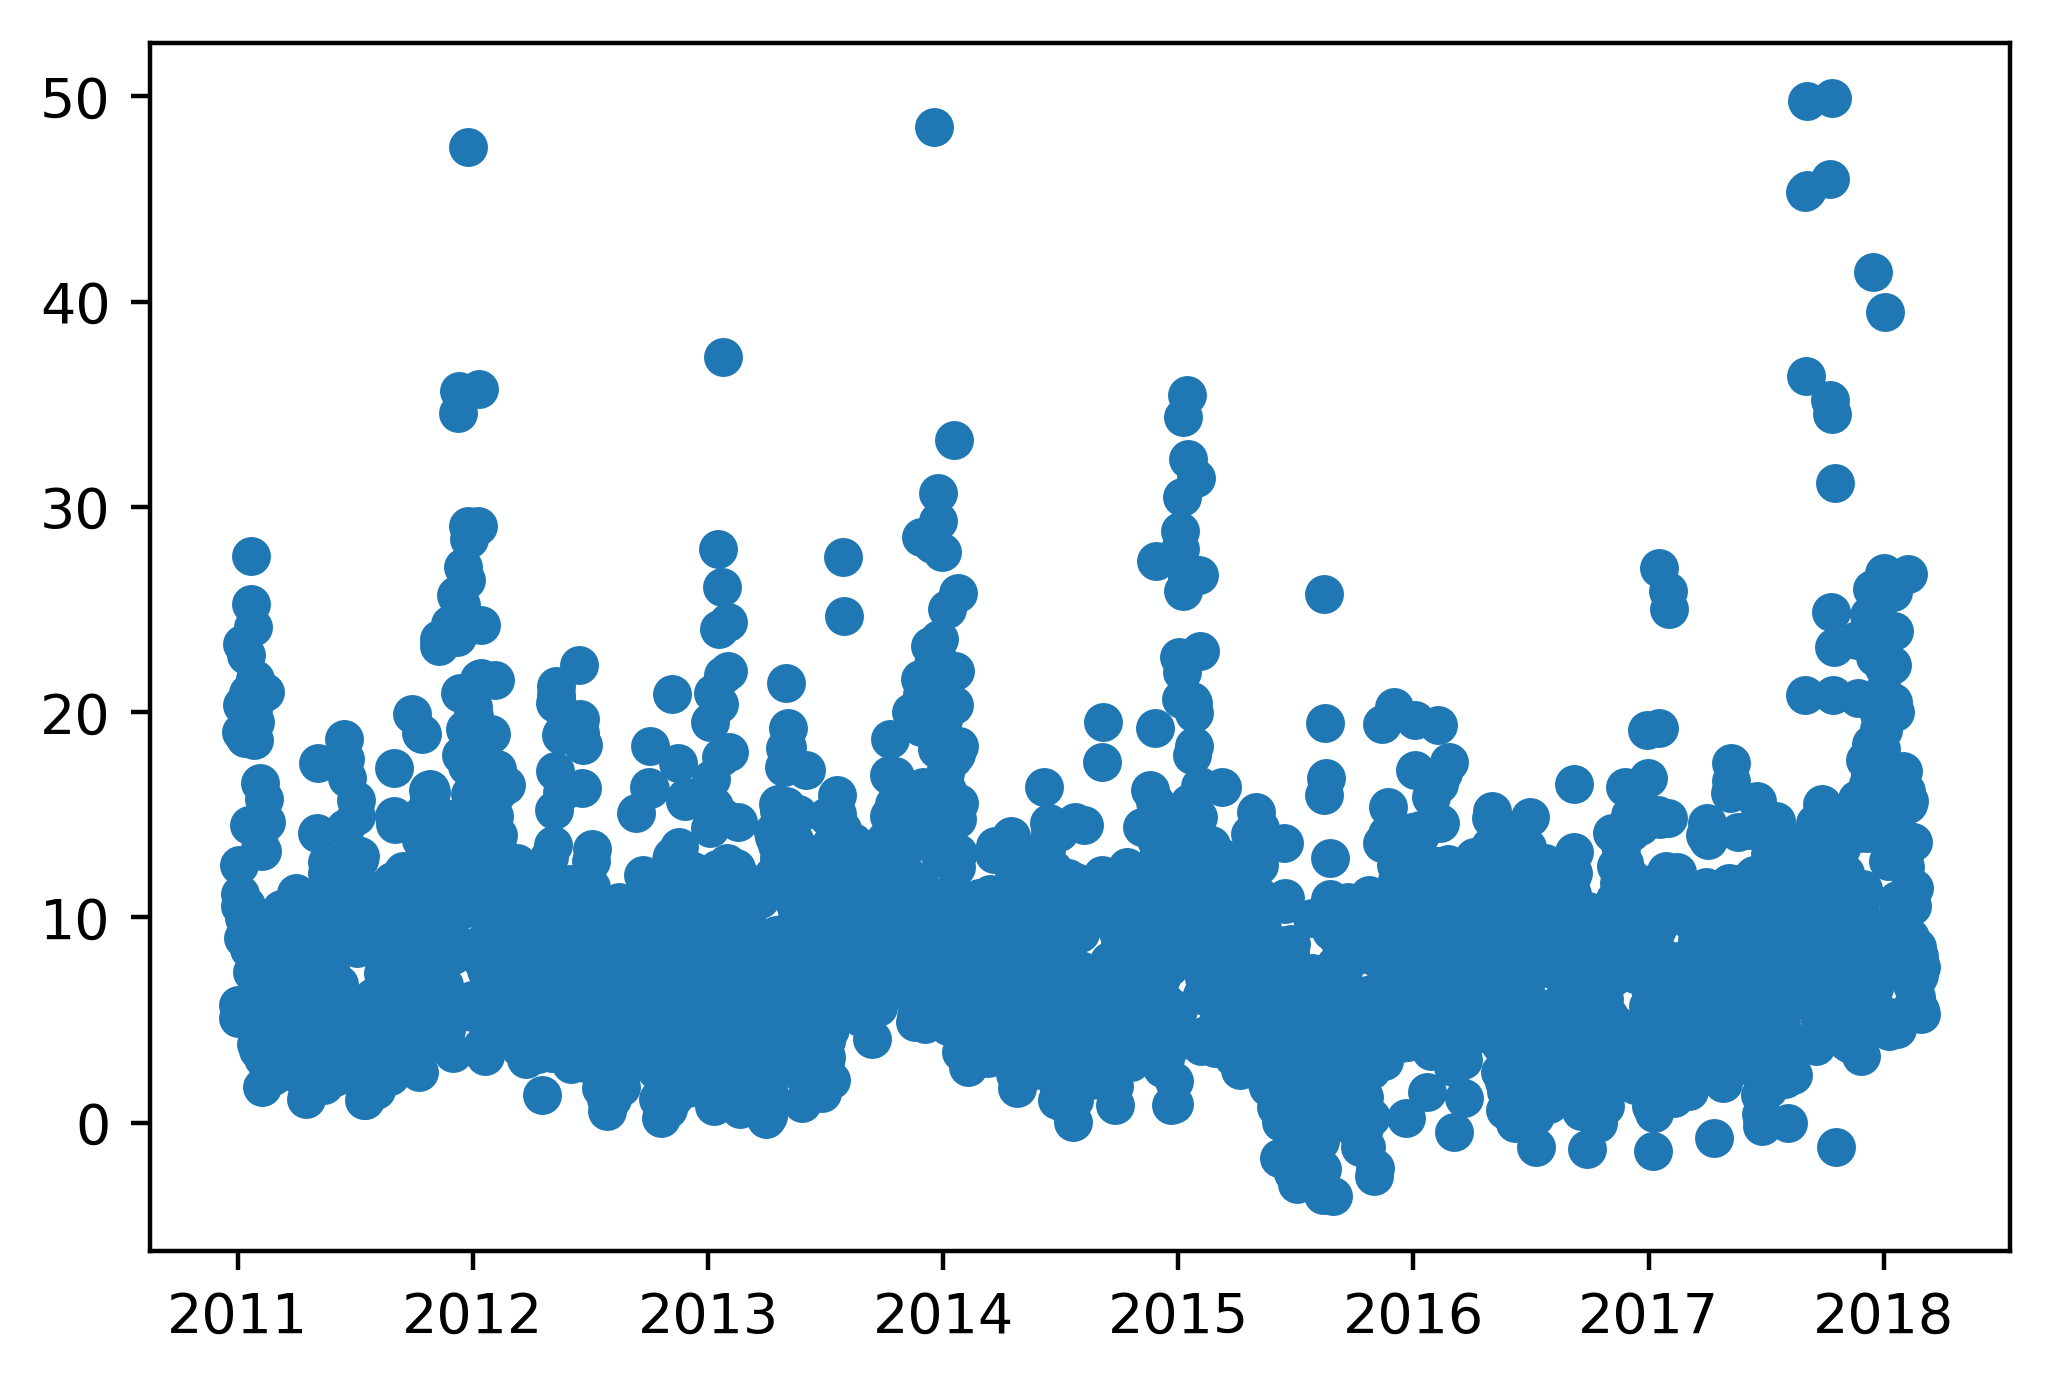

In [216]:
plt.scatter(aq.index,aq['Part Mean'])

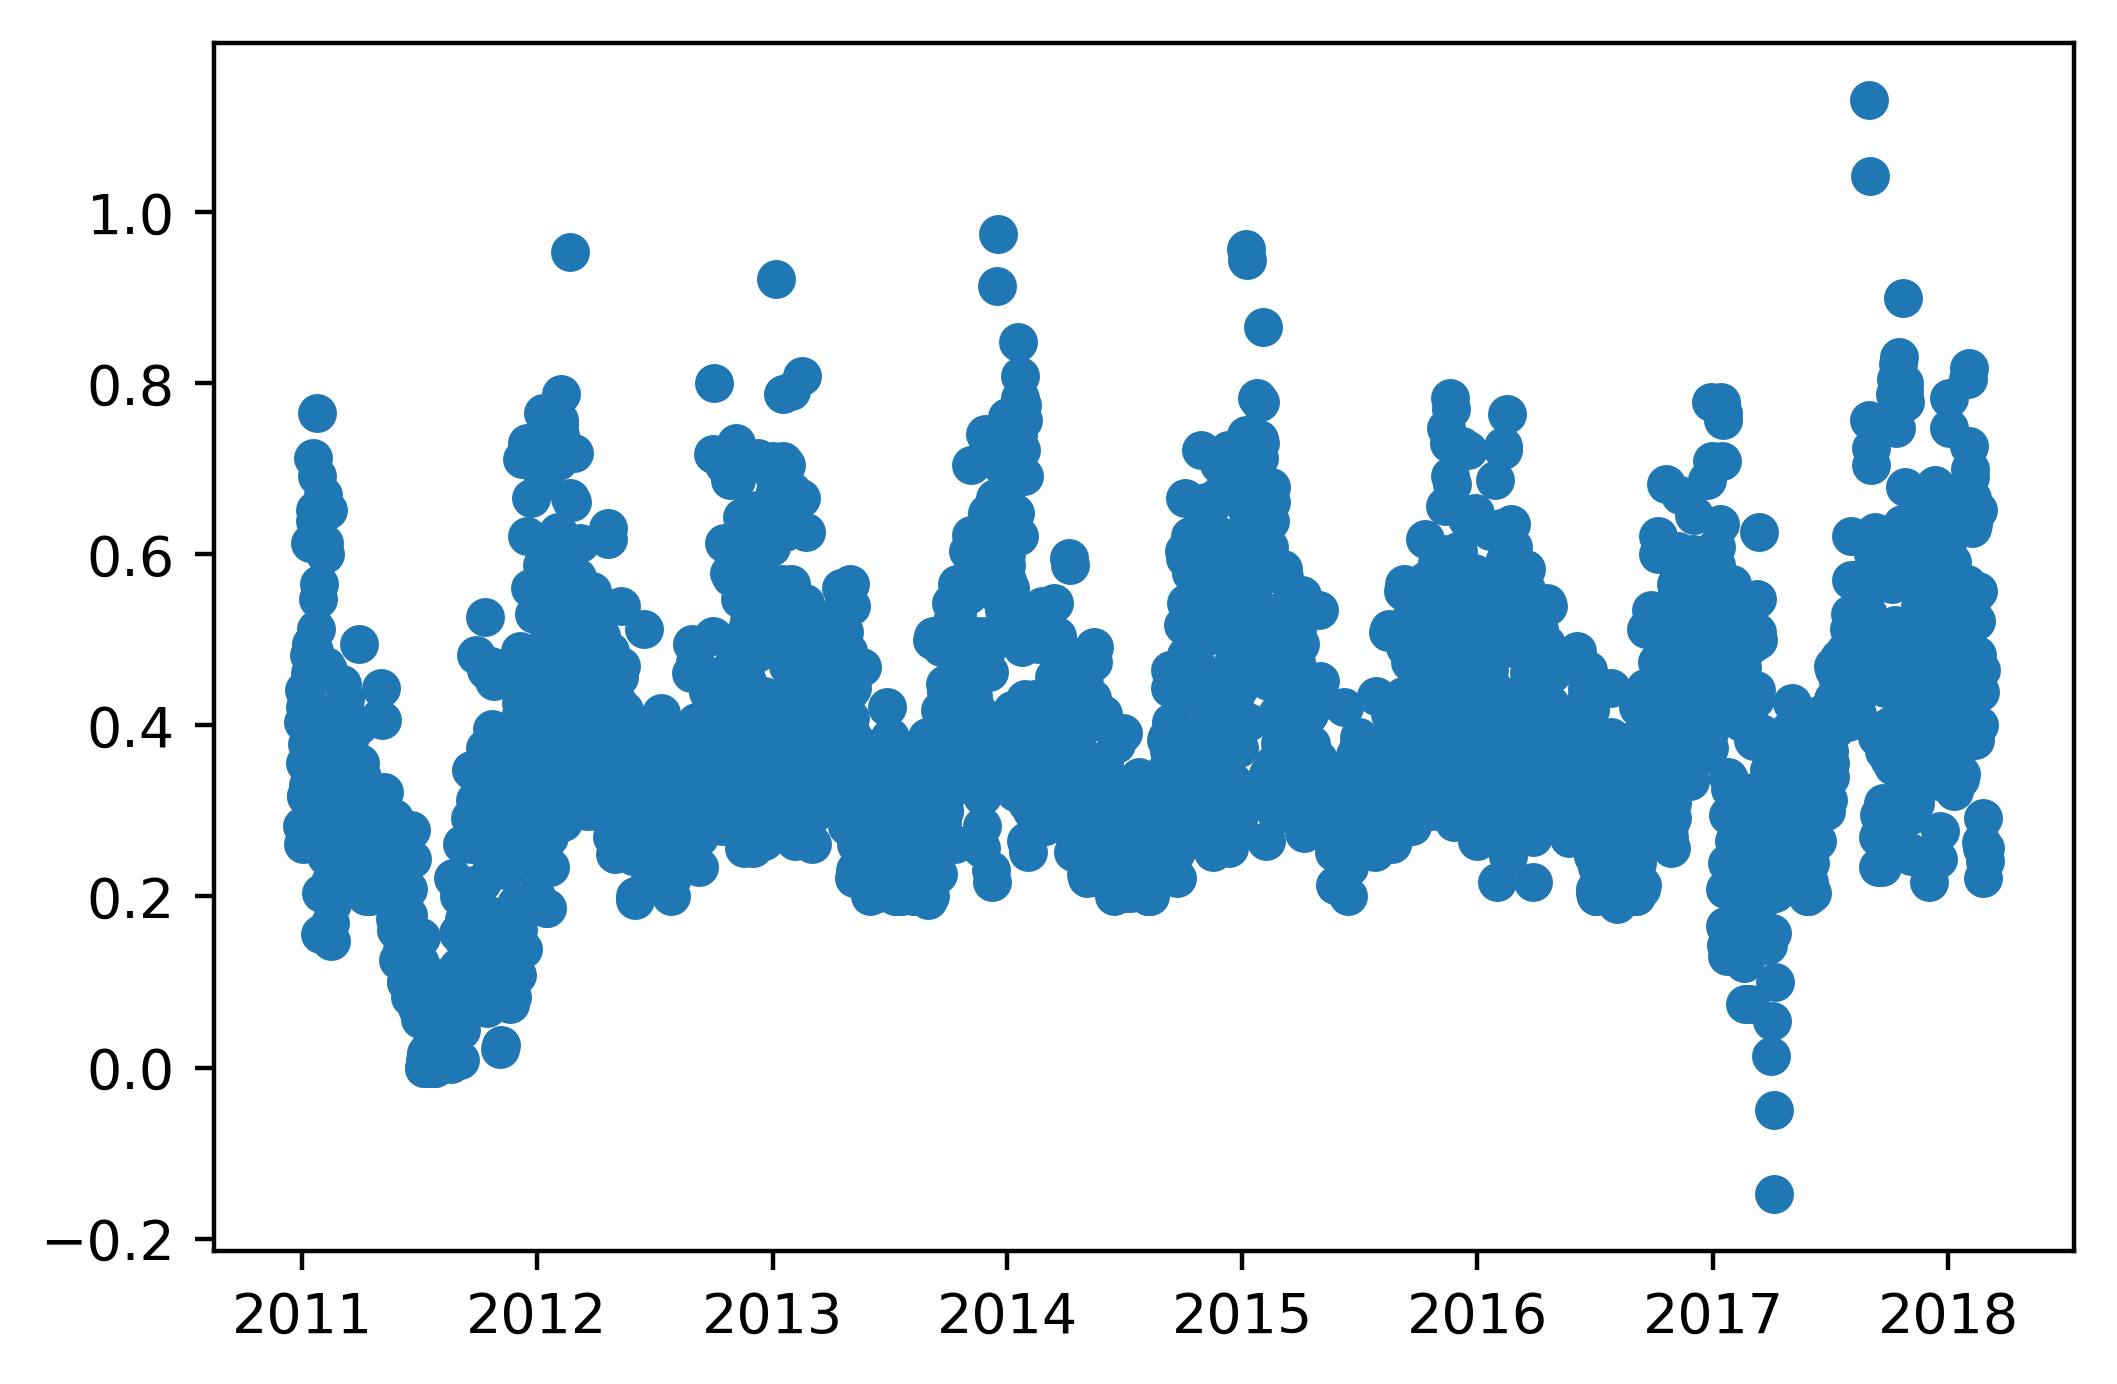

In [217]:
plt.scatter(aq.index,aq['CO Mean'])

In [799]:
          [(i,np.avg(aq[aq['Date Local']== x])) for x in aq['Date Local'].unique()]

,Latitude,Longitude,Date Local,CO Mean,CO Max Value,CO Max Hour,Oz Mean,Oz Max Value,Oz Max Hour,SO Mean,SO Max Value,SO Max Hour,Part Mean,Part Max Value,Part Max Hour,AQI,Category,AQ Defining Parameter
72,37.814781,-122.282347,2015-01-10,0.565217,1.3,4,0.008118,0.016,9,0.913636,2.4,15,17.458333,25.0,2,72,Moderate,PM2.5
73,37.814781,-122.282347,2015-01-10,0.565217,1.3,4,0.008118,0.016,9,0.913636,2.4,15,17.400000,17.4,0,72,Moderate,PM2.5
74,37.814781,-122.282347,2015-01-10,0.565217,1.3,4,0.008118,0.016,9,0.866667,1.4,14,17.458333,25.0,2,72,Moderate,PM2.5
75,37.814781,-122.282347,2015-01-10,0.565217,1.3,4,0.008118,0.016,9,0.866667,1.4,14,17.400000,17.4,0,72,Moderate,PM2.5
76,37.814781,-122.282347,2015-01-10,0.579167,1.0,5,0.008118,0.016,9,0.913636,2.4,15,17.458333,25.0,2,72,Moderate,PM2.5


In [798]:
aq['CO Mean'].diff()

72            NaN
73       0.000000
74       0.000000
75       0.000000
76       0.013950
77       0.000000
78       0.000000
79       0.000000
80      -0.013950
81       0.000000
82       0.000000
83       0.000000
84       0.038950
85       0.000000
86       0.000000
87       0.000000
104      0.174094
105      0.000000
106      0.000000
107      0.000000
108      0.050906
109      0.000000
110      0.000000
111      0.000000
136     -0.376993
137      0.000000
138      0.000000
139      0.000000
140      0.026993
141      0.000000
           ...   
17326    0.000000
17327    0.000000
17328   -0.005797
17329    0.000000
17330    0.000000
17331    0.000000
17348    0.079710
17349    0.000000
17350    0.000000
17351    0.000000
17352   -0.013043
17353    0.000000
17354    0.000000
17355    0.000000
17356    0.026087
17357    0.000000
17358    0.000000
17359    0.000000
17360   -0.005254
17361    0.000000
17362    0.000000
17363    0.000000
17364    0.044384
17365    0.000000
17366    0

In [ ]:
#creating a function to find out if the data is stationary
import statsmodels.tsa.stattools as ts
def dftest(timeseries):
    dftest = ts.adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index = ['Test Stat', 'p-value', 'Lags Used', 'Observations USed'])
    for key, value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key]=value
    print(dfoutput)
    rolmean = pd.rolling_mean(timeseries, window = 12)
    rolstd = rolling_std(timeseries, window=12)
    
    #Plotting the rolling statistics
    orig = plt.plot(timeseries, color='black' label='Original')
    mean = plt.plot(rolmean, color='blue', label='Rolling Mean')
    std = plt.plot(rolstd, color='red', label = 'Rolling Std')
    plt.legend()
    plt.title('Rolling Mean and Standard Deviation')
    plt.show(block=False);
    

In [ ]:
#helper function to visualize 
import statsmodels.tsa.api as smt

def plots(data, lags= None):
    layout =abs (1,3)
    raw = plt.subplot2grid(layout, (0,0))
    acf = plt.subplot2grid(layout, (0,1))
    pacf = plt.subplot2grid(layout, (0,2))
    
    data.plot(ax=raw)
    smt.graphics.plot(data, lags=lags, ax =acf)
    smt.graphics.plot(data, lags=lags, ax =pacf)
    sns.despine()
    plt.tight_layout();

In [ ]:
plots(aq['CO Mean', lags =75)

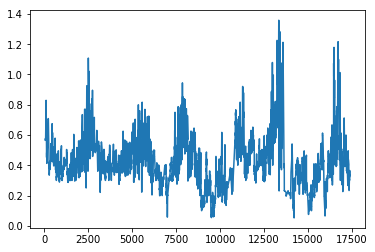

In [797]:

plt.plot(aq['CO Mean']);

# Distribution Prediction

Training a model to predict the distribution of other AQ factors in the air.  I will then cluster it all together in the next section, to find large (or larger) concentrations of the factors.

In [ ]:
from sklearn.model_selection import train_test_split

In [ ]:
X = aq[['Latitue', 'Longitude', 'CO Mean', 'SO Mean', 'Part Mean', 'Oz Mean']]
y = df[df['latlong'].isin(list(aq['latlong']))]['co2ppm']

In [ ]:
from sklearn.naive_bayes import GaussianNB
gnb = GaussianNB()
y_pred = gnb.fit(iris.data, iris.target)

# Clustering

Now that I am done with the EDA and data cleaning, I am goign to cluster the air quality data.

In [759]:
from sklearn.cluster import KMeans, MiniBatchKMeans
from sklearn.cluster import KMeans
from sklearn.utils import shuffle
from sklearn import preprocessing
from sklearn import metrics
from sklearn.metrics.pairwise import euclidean_distances
from sklearn.metrics import pairwise_distances
from sklearn.metrics import silhouette_score


In [761]:
clusterdf = aq[['CO Mean', 'SO Mean', 'Part Mean', 'Oz Mean']]

In [766]:
km.inertia_

2751.600271664947

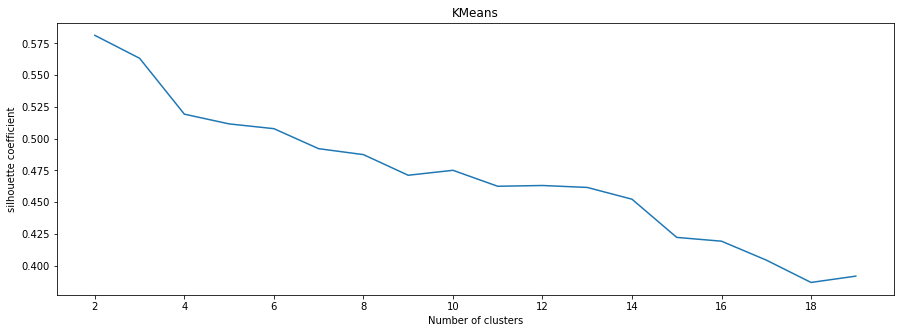

In [795]:
Sil_coefs = []
inertia = []
for k in range(2,20):
    km = KMeans(n_clusters = k)
    km.fit(clusterdf)
    labels = km.labels_
    Sil_coefs.append(metrics.silhouette_score(clusterdf, labels, metric='euclidean'))
    inertia.append(km.inertia_)
fig, ax1 = plt.subplots(1,1, figsize=(15,5), sharex=True)
k_clusters = range(2,20)
ax1.plot(k_clusters, Sil_coefs)
#inertia says 4 clusters, silhouette is about .51
ax1.set_title('KMeans')
ax1.set_xlabel('Number of clusters')
ax1.set_ylabel('silhouette coefficient')
plt.xticks(np.arange(2, 20, step=2));

In [783]:
km = KMeans(n_clusters = 4)
km.fit(clusterdf)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=4, n_init=10, n_jobs=1, precompute_distances='auto',
    random_state=None, tol=0.0001, verbose=0)

In [784]:
mu_digits = km.cluster_centers_
kmlabels = km.labels_

In [787]:
print(len(kmlabels))
print(len(clusterdf))

11742
11742


# Time Series Exploration

Starting on time series items.  Checking for stationarity, ploting concentrations vs time.

In [83]:
import plotly.plotly as py
import plotly.graph_objs as go
import plotly
import statsmodels.tsa.api as smt
import statsmodels.api as sm
import statsmodels.tsa.stattools as ts
"""plotly.tools.set_credentials_file(username='djmorcode', api_key='g4D9PR85TaaUkKlH8CWZ')
data = [go.Scatter(x=annual_temp.index, y=annual_temp.temp)]
py.iplot(data)"""

"plotly.tools.set_credentials_file(username='djmorcode', api_key='g4D9PR85TaaUkKlH8CWZ')\ndata = [go.Scatter(x=annual_temp.index, y=annual_temp.temp)]\npy.iplot(data)"

In [41]:
"""#pulling in climate data
with open('climate_data.pkl', 'rb') as picklefile:
    aq = pickle.load(picklefile)
"""

"#pulling in climate data\nwith open('climate_data.pkl', 'rb') as picklefile:\n    aq = pickle.load(picklefile)\n"

In [84]:
aq2.head()

,State Name,county Name,State Code,County Code,Date,AQI,Category,Defining Parameter,Defining Site,Number of Sites Reporting
0,Alabama,Baldwin,1,3,2008-01-04,38,Good,PM2.5,01-003-0010,1
1,Alabama,Baldwin,1,3,2008-01-07,15,Good,PM2.5,01-003-0010,1
2,Alabama,Baldwin,1,3,2008-01-10,15,Good,PM2.5,01-003-0010,1
3,Alabama,Baldwin,1,3,2008-01-13,38,Good,PM2.5,01-003-0010,1
4,Alabama,Baldwin,1,3,2008-01-16,31,Good,PM2.5,01-003-0010,1


In [94]:
aq2.reset_index(level=0, inplace=True, drop=True)
aq2.drop_duplicates('Date Local',inplace=True)
aq2['Date Local'] = pd.to_datetime(aq2['Date Local'])
aq = aq2[['AQI', 'Date Local']].copy()

In [95]:
#aq2.set_index('Date Local', inplace=True)
aq2.head()

,County Name,Date Local,AQI,Category,AQ Defining Parameter
0,San Francisco,2008-01-01,66,Moderate,PM2.5
1,San Francisco,2008-01-02,69,Moderate,PM2.5
2,San Francisco,2008-01-03,36,Good,PM2.5
3,San Francisco,2008-01-04,33,Good,Ozone
4,San Francisco,2008-01-05,32,Good,PM2.5


In [96]:
sfc.set_index('Date', inplace=True)
aq2 = aq2.set_index(pd.DatetimeIndex(aq2['Date Local']))

In [97]:
len(sfc)/len(sfc['CO2 ppm'].resample('D').mean())

0.7441516138584543

In [262]:
cc = sfc['CO2 ppm'].resample('D').mean()
aqi

In [264]:
cc.isnull().values.any()

True

In [71]:
cc = sfc['CO2 ppm'].resample('W').mean()
aqi = aq2['AQI'].resample('W').mean()

TypeError: Only valid with DatetimeIndex, TimedeltaIndex or PeriodIndex, but got an instance of 'Int64Index'

In [244]:
sfc.head()

,CO2 ppm,latlong
Date,,
2008-01-02,397.260010,"(37.76, -122.45)"
2008-01-03,390.620000,"(37.76, -122.45)"
2008-01-04,390.169997,"(37.76, -122.45)"
2008-01-05,388.109998,"(37.76, -122.45)"
2008-01-06,388.410001,"(37.76, -122.45)"


In [104]:
def missVal(colname,df1):
    dates = df1.resample('D').asfreq().index
    coppm = list(np.arange(len(dates)))


    df = pd.DataFrame({'dates':list(dates),
                   colname:coppm}, columns=['dates',colname])

    for i in range(len(df)):
        if df.dates.values[i] in df1.index.values:
            cd =df.dates[i]
            last_val = df1.loc[cd,colname]
            df.loc[i,colname] = last_val
        elif df.dates.values[i+1] in df1.index.values:
            nday = df.dates[i]+datetime.timedelta(days = 1)
            avalue = df1.loc[nday,colname]
            df.loc[i,colname] =(avalue+last_val)/2
        else:
            df.loc[i,colname] =last_val
    return df

In [105]:
aq.index = pd.to_datetime(aq.index)
sfc.index = pd.to_datetime(sfc.index)

In [106]:
#no longer have missing values
cdf = missVal('CO2 ppm', sfc)
aqidf = missVal('AQI', aq)
cdf.set_index('dates',inplace=True)
aqidf.set_index('dates',inplace=True)

In [107]:
cdf

,CO2 ppm
dates,
2008-01-02,397.260010
2008-01-03,390.620000
2008-01-04,390.169997
2008-01-05,388.109998
2008-01-06,388.410001
2008-01-07,388.059998
2008-01-08,387.940003
2008-01-09,388.470013
2008-01-10,397.310010


In [112]:
cdf.isnull().values.any()

False

In [110]:
nulls = aqidf[aqidf.isnull().values].copy()

In [293]:
#For nulls, if any are in dataset
for i in nulls.index:
    prevdate = i-datetime.timedelta(days = 2)
    postdate = i+datetime.timedelta(days = 5)
    fill = (aq.loc[prevdate,'AQI']+aq.loc[postdate,'AQI'])/2
    aqidf.loc[i,'AQI'] = fill

In [294]:
# plot binned yearly segments using resample method, capital A for annual
#monthly_temp.resample('A').temp.plot();

In [295]:
# violinplot months to determine variance and range
#sns.violinplot(x=monthly_temp.index.month, y=monthly_temp.temp);

## Time Series with Prophet

Facebooks Prophet package is better atm with my data because it is incomplete and it allows for specifying change points in the trend to give an idea of how an event will affect forecasting into the future.

In [118]:
from fbprophet import Prophet
from sklearn.model_selection import train_test_split

In [131]:
cdf.drop('index',axis=1,inplace=True)

In [128]:
cdf.reset_index(inplace=True, drop=True)
aq2.reset_index(inplace=True, drop=True)

In [137]:
paq = aq2[['Date Local','AQI']]
paq.columns = ['ds','y']
cdf.columns = ['ds','y']

In [138]:
cdf.head()

,ds,y
0,2008-01-02,397.260010
1,2008-01-03,390.620000
2,2008-01-04,390.169997
3,2008-01-05,388.109998
4,2008-01-06,388.410001


In [140]:
paq.head()

,ds,y
0,2008-01-01,66
1,2008-01-02,69
2,2008-01-03,36
3,2008-01-04,33
4,2008-01-05,32


In [ ]:
#adding events into prophet 
verticalforest = pd.DataFrame({
  'event': 'vertical forest',
  'ds': pd.to_datetime(['2020-1-1']),
  'lower_window': -14,
  'upper_window': 14,
})
citytree = pd.DataFrame({
  'event': 'city tree',
  'ds': pd.to_datetime(['2020-1-1']),
  'lower_window': -14,
  'upper_window': 14,
})

In [141]:
ctrain, ctest = train_test_split(cdf, test_size = .3, shuffle = False)
atrain,atest = train_test_split(aq2, test_size = .3, shuffle = False)

In [169]:
m = Prophet(yearly_seasonality=True, weekly_seasonality=True, daily_seasonality=False)
m.fit(ctrain)

/anaconda3/lib/python3.6/site-packages/pystan/misc.py:399: FutureWarning:

Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.



In [170]:
future = m.make_future_dataframe(periods=1025)

In [171]:
forecast = m.predict(future)

In [189]:
_, yhat = train_test_split(forecast, test_size = .3, shuffle = False)

In [190]:
dif = len(ctest)-len(yhat)
yhat.drop(yhat.index[:-dif], inplace=True)

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



In [192]:
yhat=yhat['yhat']

In [174]:
forecast.tail()

,ds,trend,trend_lower,trend_upper,yhat_lower,yhat_upper,additive_terms,additive_terms_lower,additive_terms_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,yhat
3383,2017-04-07,409.208061,384.229573,432.727077,387.658599,436.582576,3.298706,3.298706,3.298706,0.0,0.0,0.0,-0.074886,-0.074886,-0.074886,3.373592,3.373592,3.373592,412.506767
3384,2017-04-08,409.216141,384.202408,432.787598,387.379736,436.091960,3.381652,3.381652,3.381652,0.0,0.0,0.0,-0.051655,-0.051655,-0.051655,3.433307,3.433307,3.433307,412.597793
3385,2017-04-09,409.224222,384.175243,432.830881,387.159493,436.530462,3.267059,3.267059,3.267059,0.0,0.0,0.0,-0.223089,-0.223089,-0.223089,3.490148,3.490148,3.490148,412.491282
3386,2017-04-10,409.232303,384.148078,432.874148,387.130411,436.835165,3.347477,3.347477,3.347477,0.0,0.0,0.0,-0.195538,-0.195538,-0.195538,3.543015,3.543015,3.543015,412.579780
3387,2017-04-11,409.240384,384.120913,432.915420,388.856665,437.459427,4.224178,4.224178,4.224178,0.0,0.0,0.0,0.633355,0.633355,0.633355,3.590822,3.590822,3.590822,413.464561


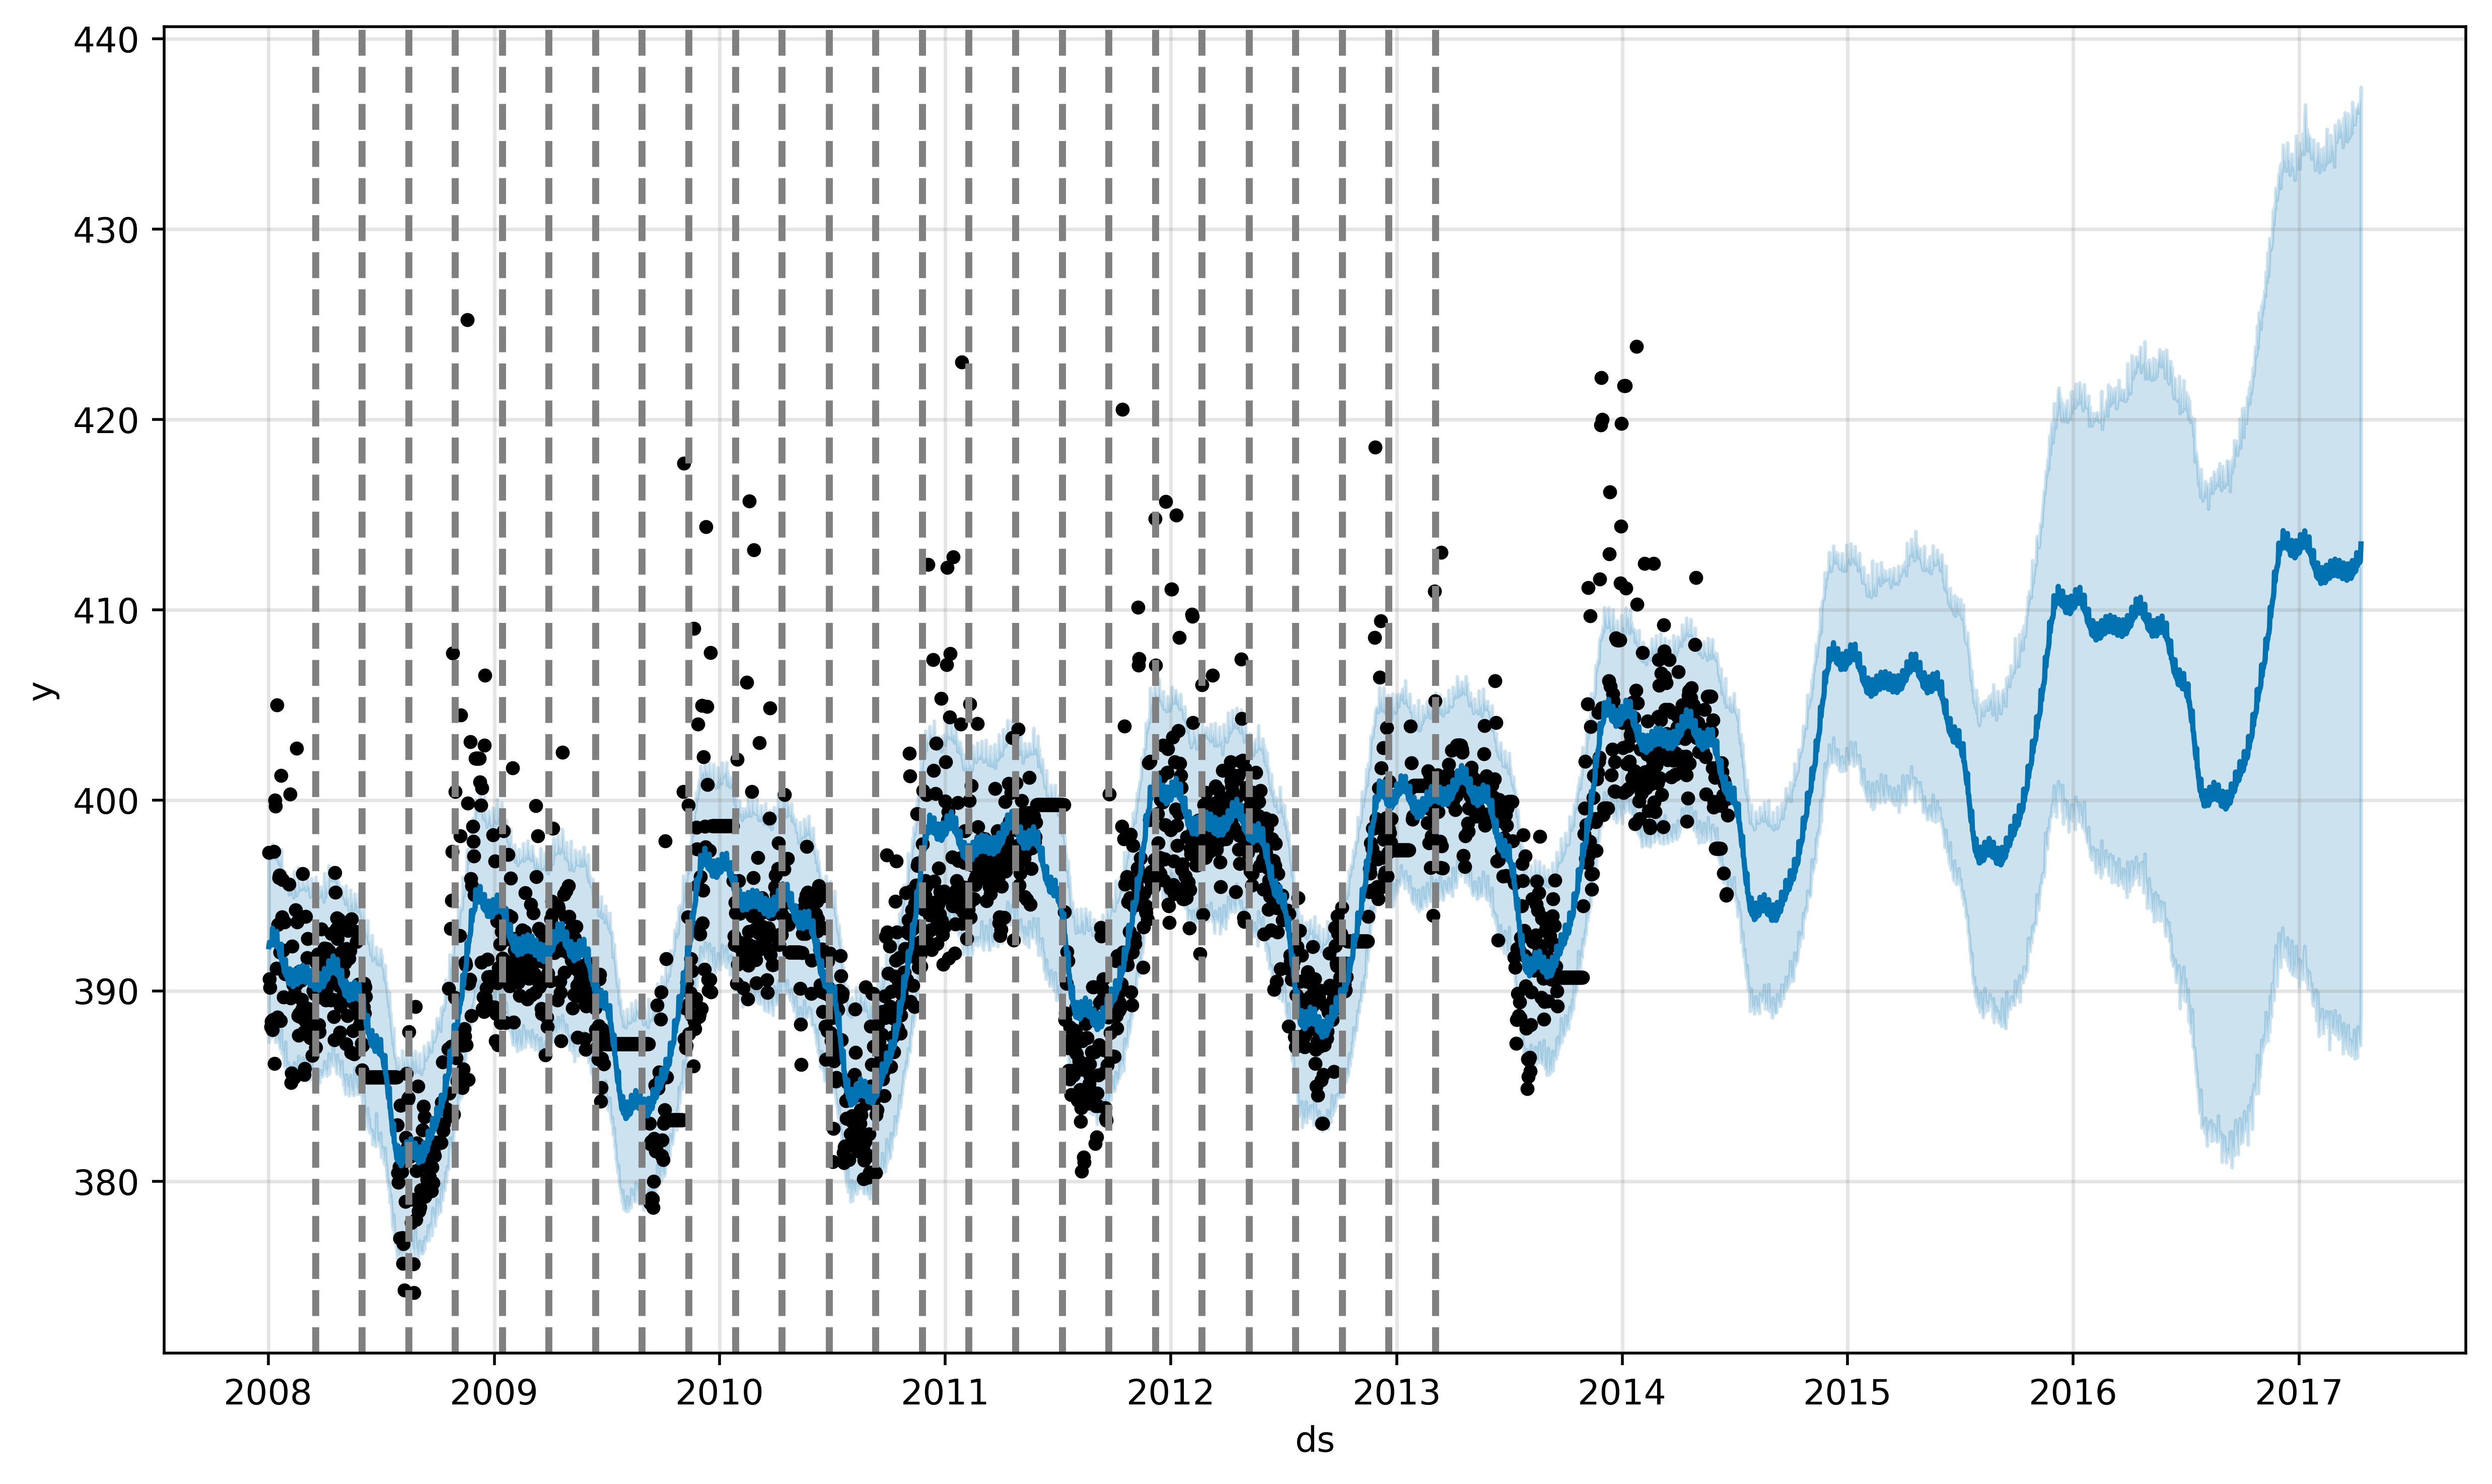

In [198]:
fig = m.plot(forecast);
for cp in m.changepoints:
    plt.axvline(cp,c='gray', ls='--',lw=2)

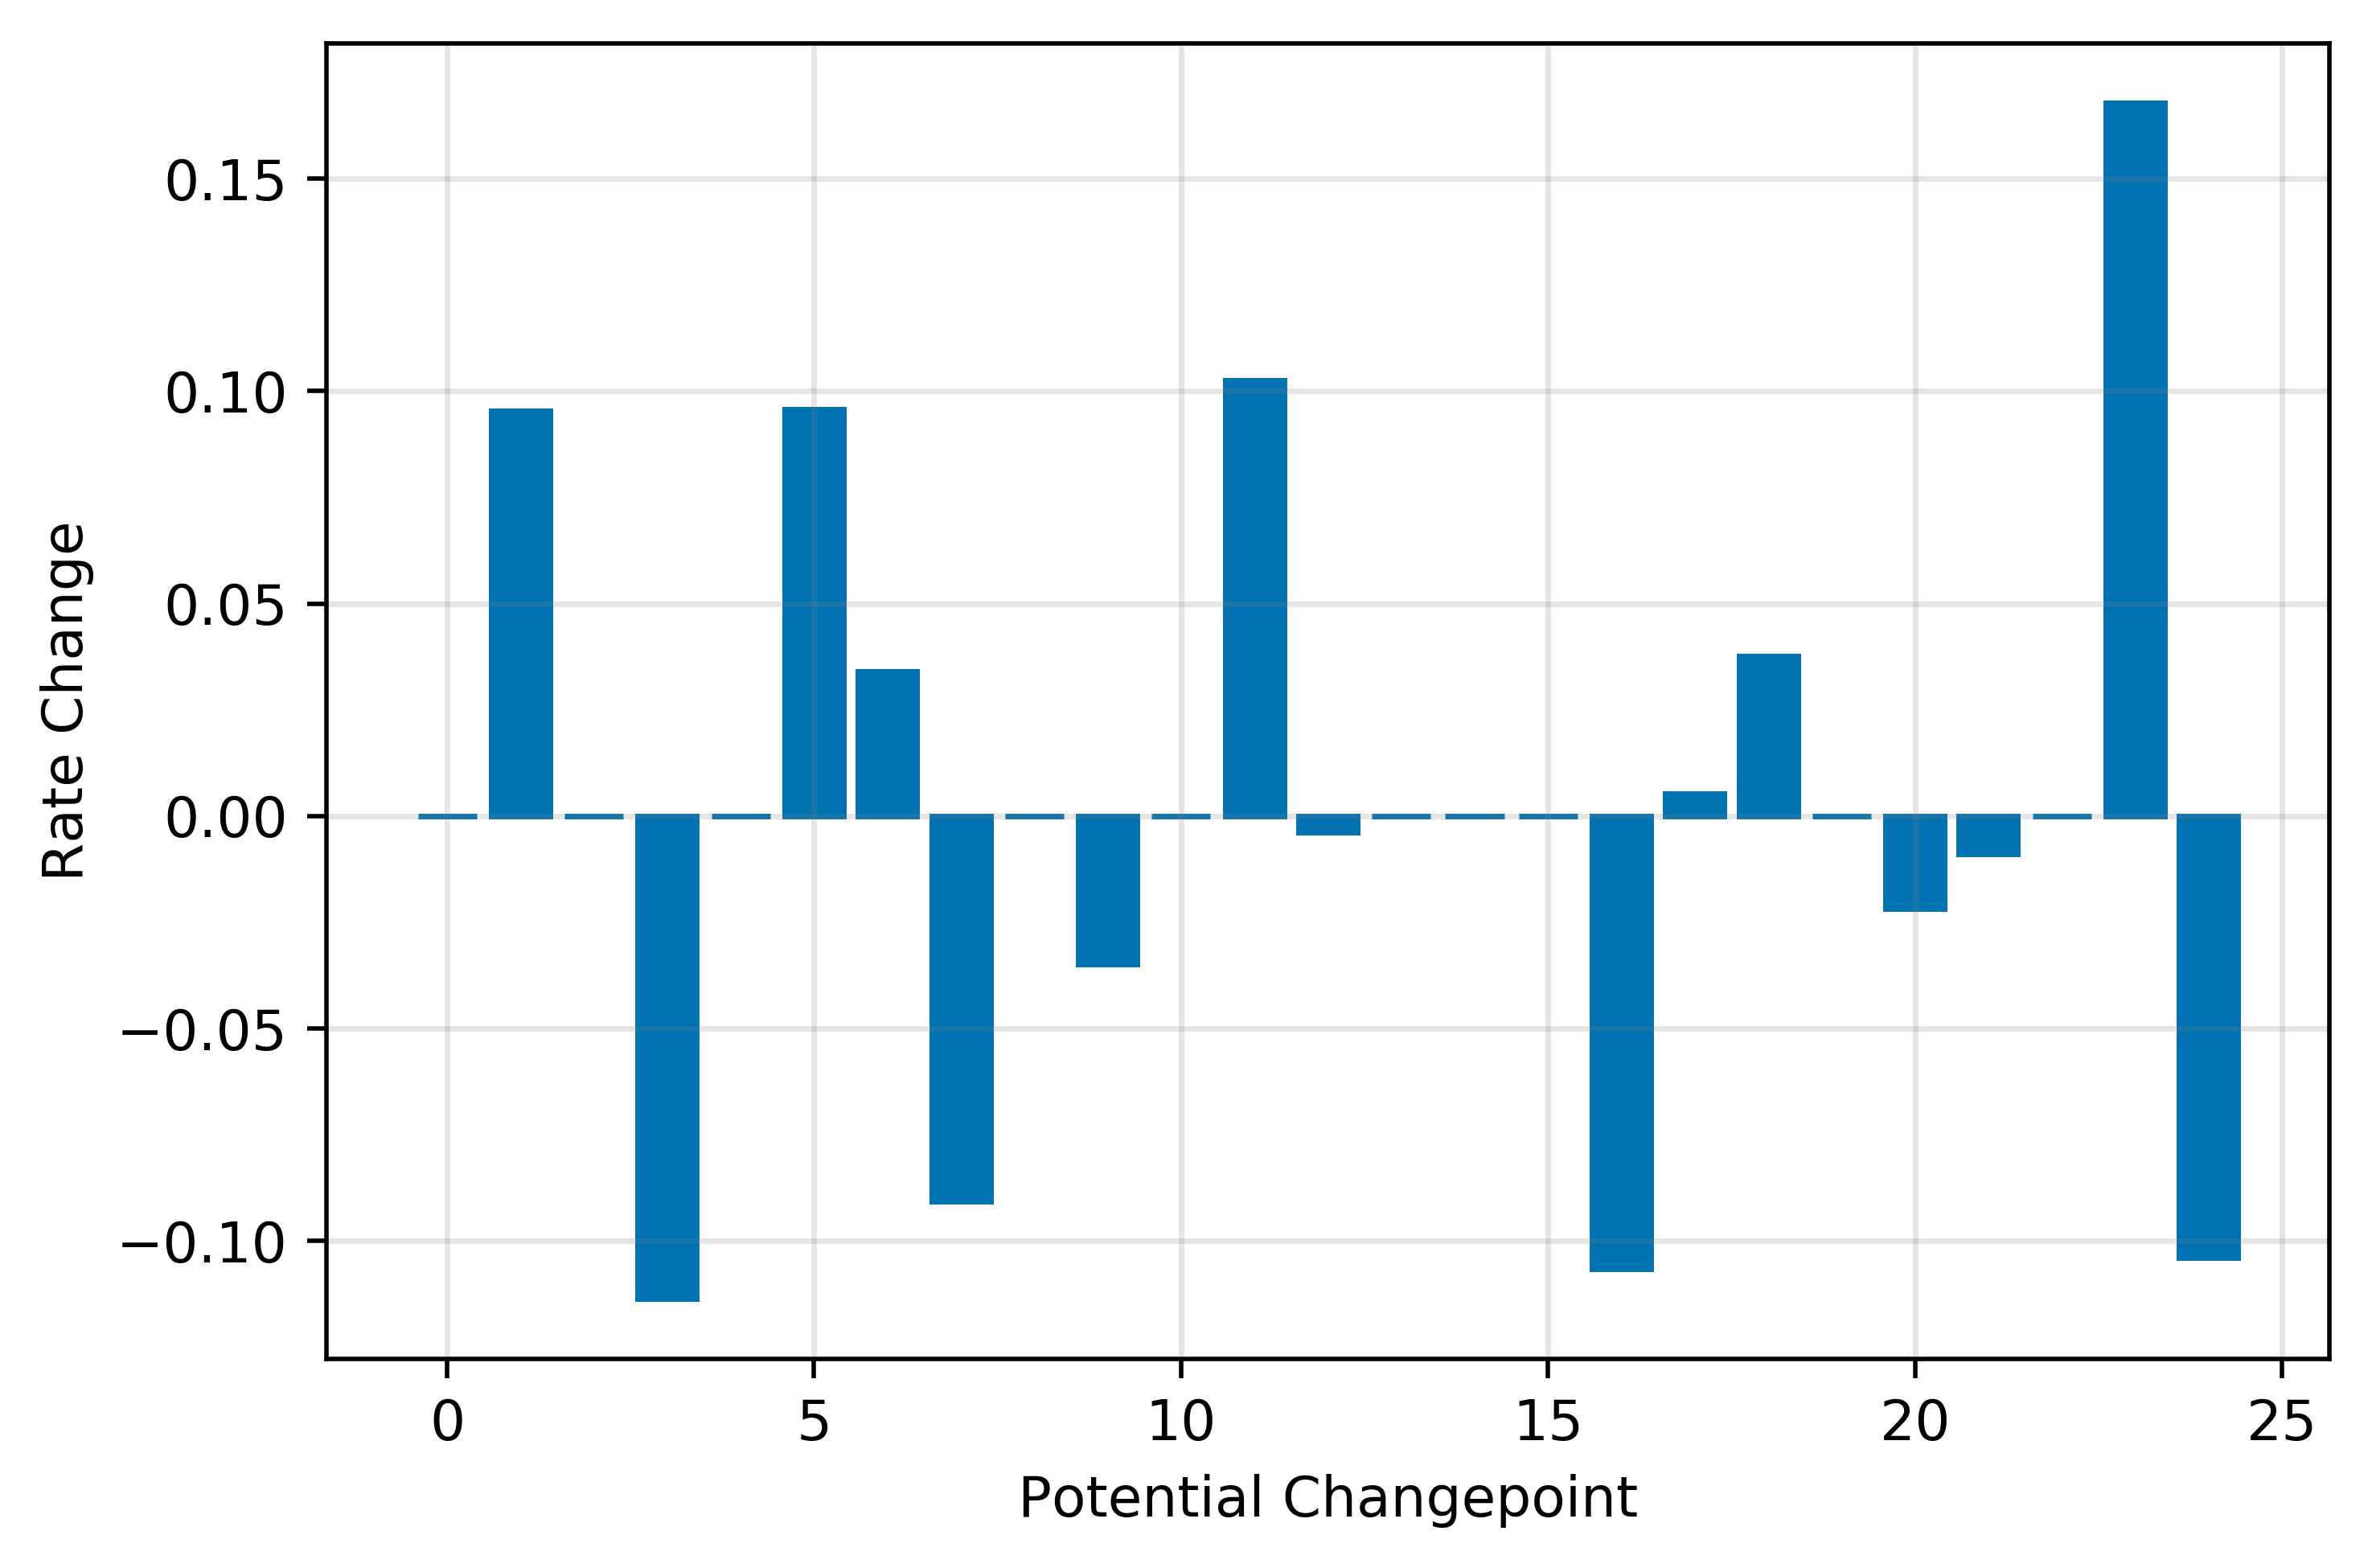

In [203]:
deltas = m.params['delta'].mean(0)
fig = plt.figure(facecolor='white')
ax = fig.add_subplot(111)
ax.bar(range(len(deltas)), deltas, facecolor='#0072B2', edgecolor='#0072B2')
ax.grid(True,which='Major',c='gray',ls='-',lw=1, alpha=.2)
ax.set_ylabel('Rate Change')
ax.set_xlabel('Potential Changepoint')
fig.tight_layout()

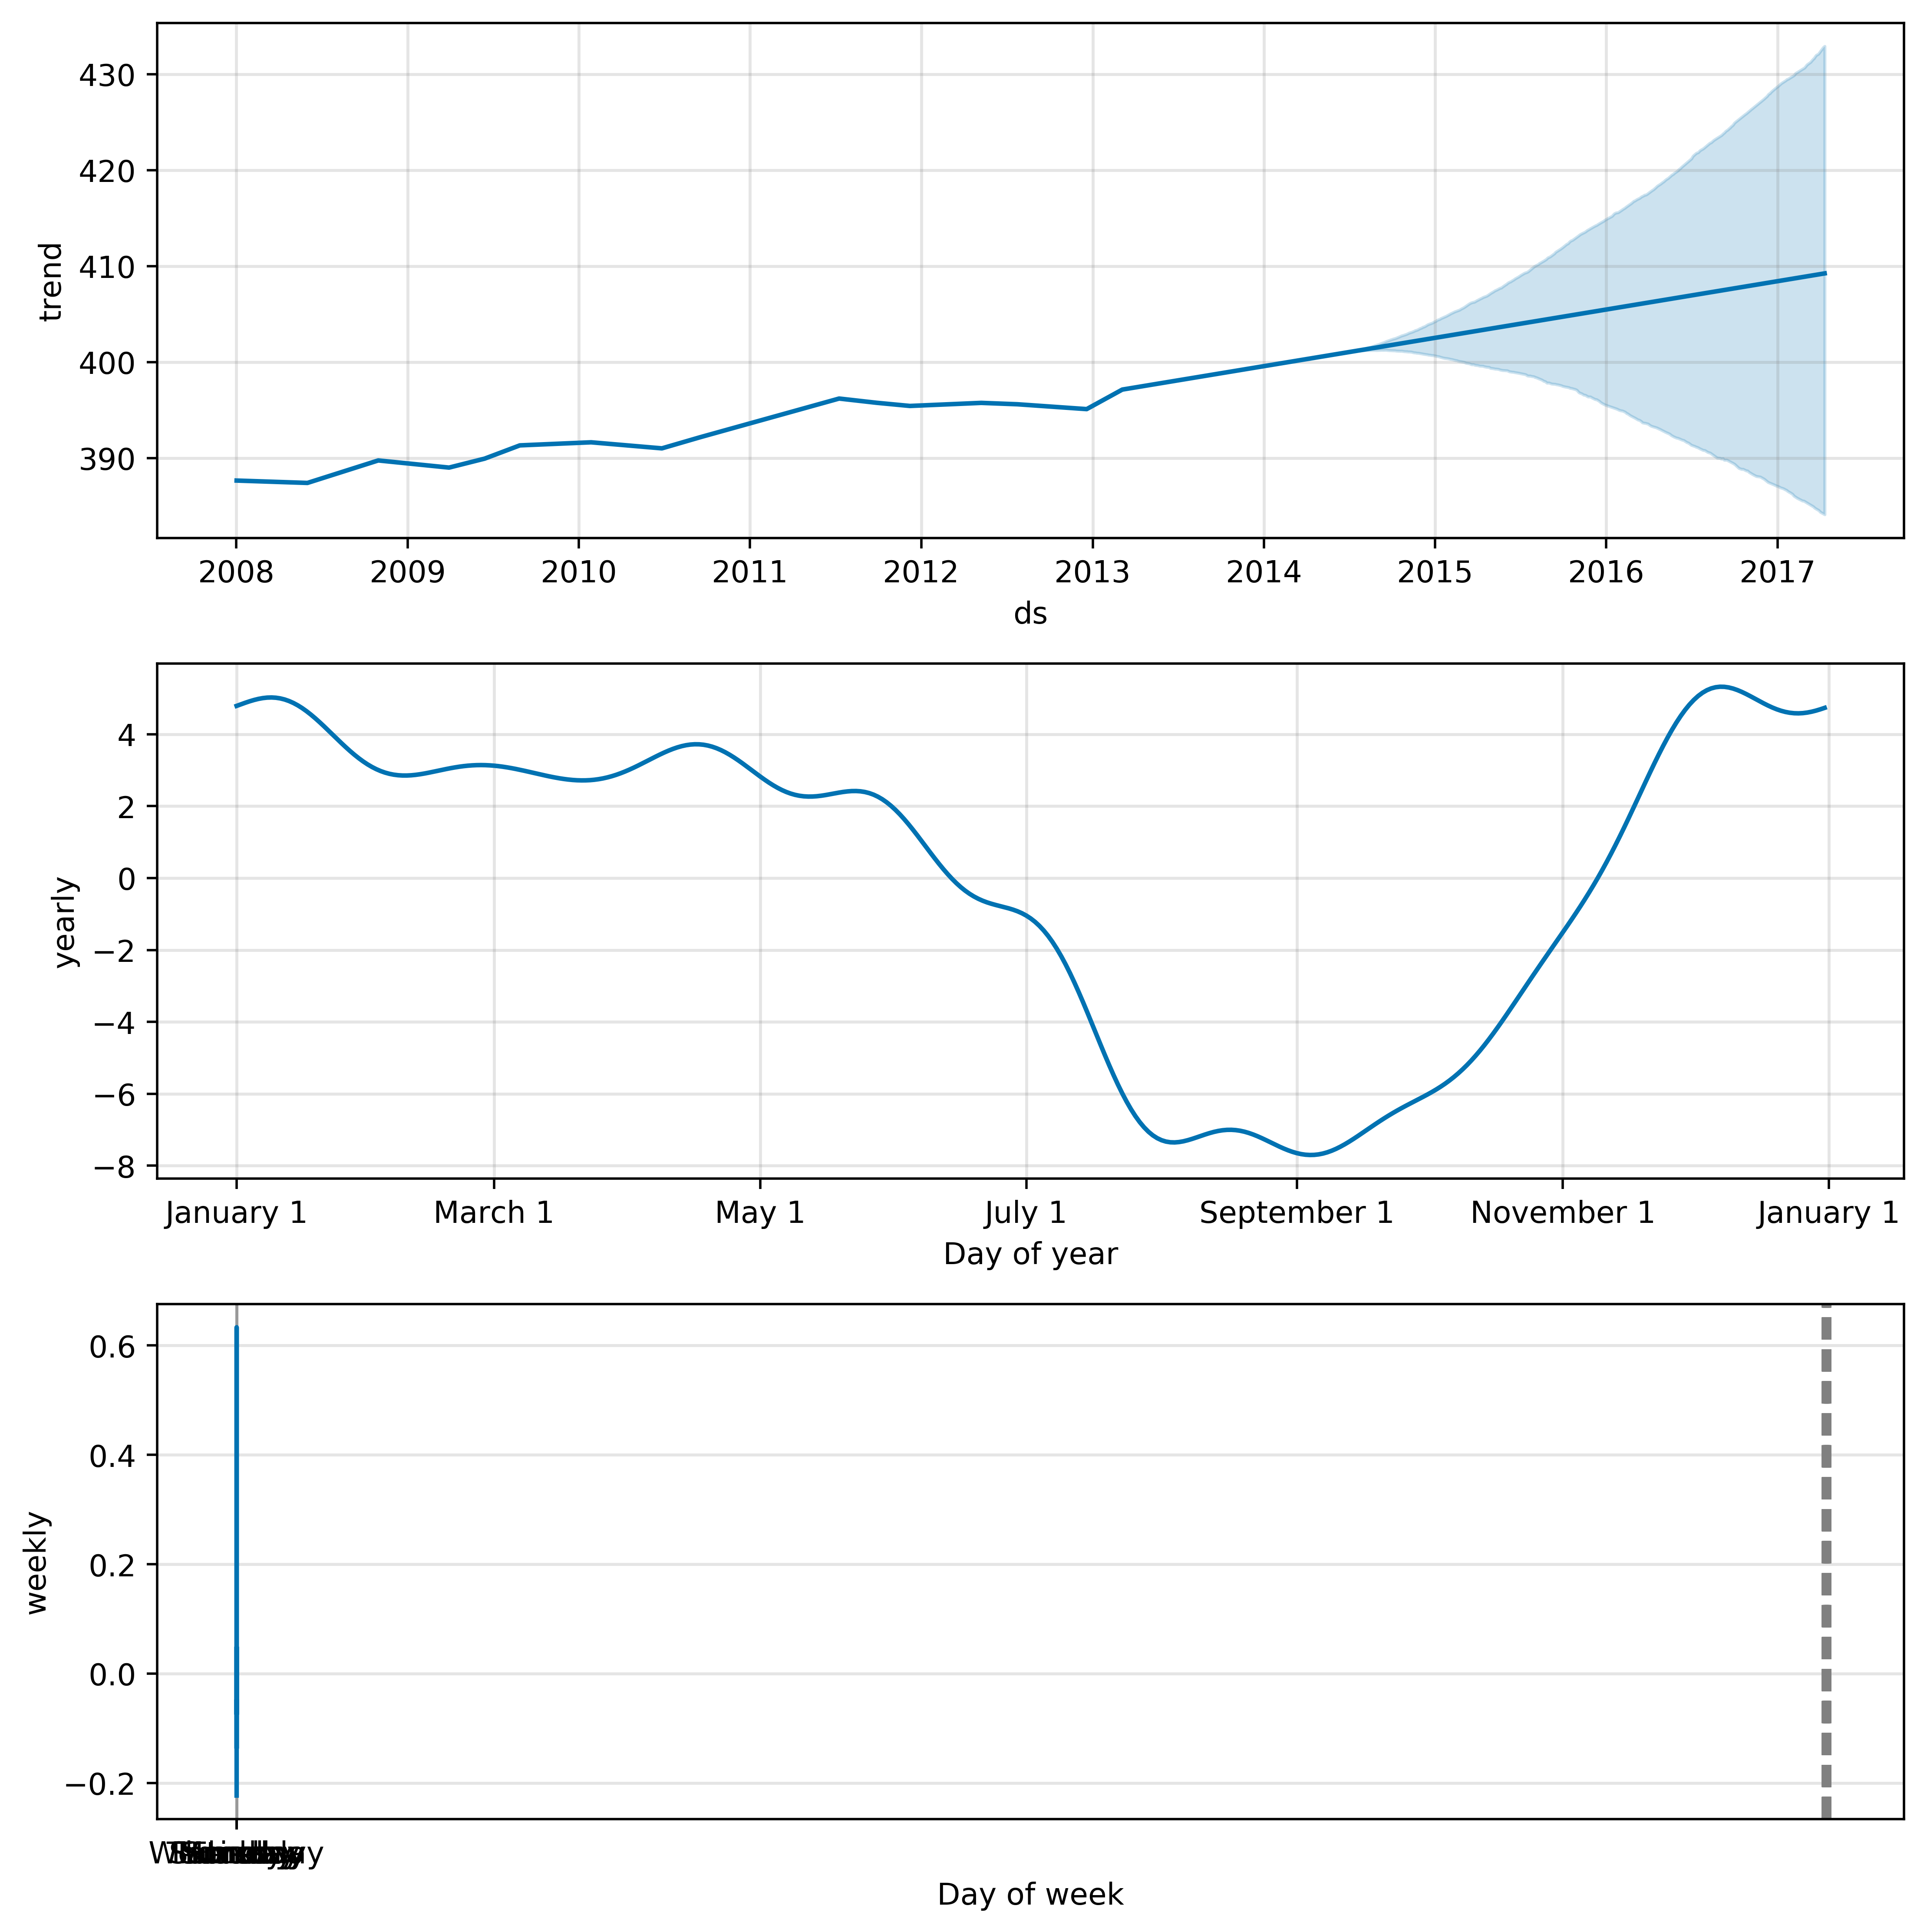

In [199]:
m.plot_components(forecast);

In [194]:
#predictions are 4.78 ppm off from the actual values
rms = math.sqrt(mean_squared_error(ctest['y'], yhat))
rms

4.768537937951613

In [151]:
q = Prophet(yearly_seasonality=True, weekly_seasonality=True, daily_seasonality=False)

In [152]:
q.fit(paq)

INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
/anaconda3/lib/python3.6/site-packages/pystan/misc.py:399: FutureWarning:

Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.



In [160]:
fut2 = q.make_future_dataframe(periods=1095)

In [161]:
fore2 = q.predict(fut2)

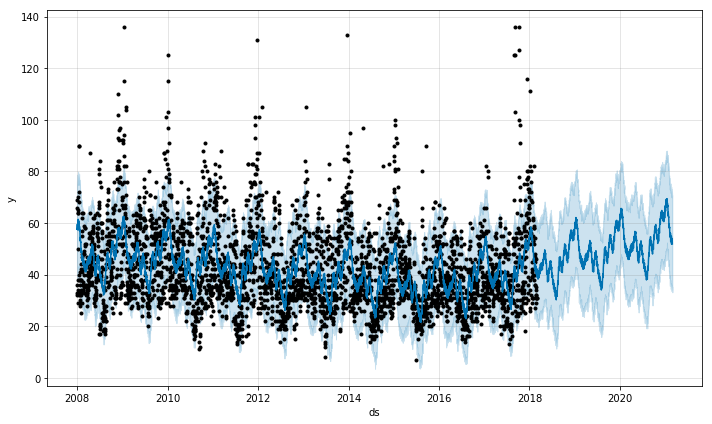

In [162]:
q.plot(fore2);

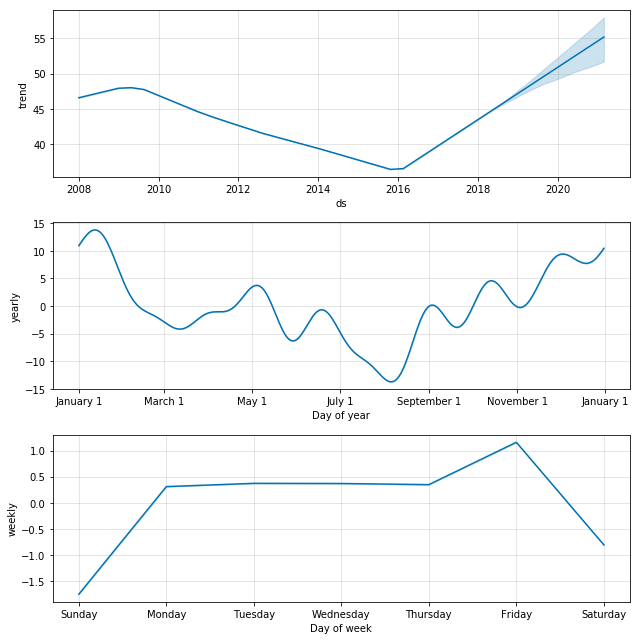

In [163]:
q.plot_components(fore2);

## Time Series with SARIMAX

Below is the start of the time series predictions.  I will actually start with Prophet since my data is incomplete, then check how it looks with sarmiax after predicting the missing data.

In [304]:
# decompose data into trend, seasonal, and residual
decomposition = sm.tsa.seasonal_decompose(cdf, model='additive')
fig = decomposition.plot()
plt.show()

ValueError: operands could not be broadcast together with shapes (3377,2) (3377,) 

In [209]:
# define Dickey-Fuller Test (DFT) function
import statsmodels.tsa.stattools as ts
def dftest(timeseries):
    dftest = ts.adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','Lags Used','Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput)
    #Determing rolling statistics
    rolmean = pd.rolling_mean(timeseries, window=7)
    rolstd = pd.rolling_std(timeseries, window=7)

    #Plot rolling statistics:
    orig = plt.plot(timeseries, color='blue',label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    #std = plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean and Standard Deviation')
    plt.show(block=False)

In [299]:
# run DFT on monthly, how many lags back that are used to determine if thereis an underlying trend
dftest(cdf)

ValueError: too many values to unpack (expected 2)

Test Statistic         -7.323486e+00
p-value                 1.177434e-10
Lags Used               1.000000e+00
Observations Used       3.730000e+02
Critical Value (1%)    -3.448004e+00
Critical Value (5%)    -2.869320e+00
Critical Value (10%)   -2.570915e+00
dtype: float64


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: FutureWarning:

pd.rolling_mean is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(window=7,center=False).mean()

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: FutureWarning:

pd.rolling_std is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(window=7,center=False).std()



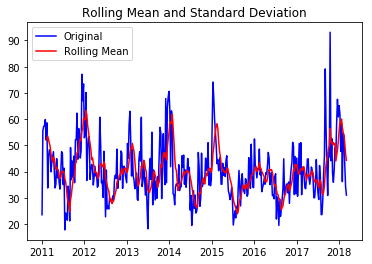

In [211]:
dftest(aqi)

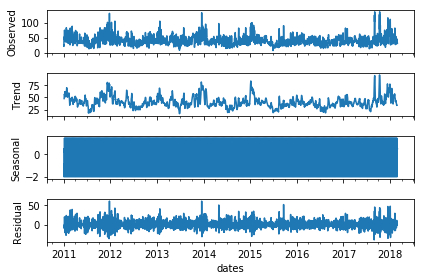

In [35]:
# decompose data into trend, seasonal, and residual
decomposition = sm.tsa.seasonal_decompose(aqidf.AQI)
fig = decomposition.plot()
plt.show()

In [36]:
# define helper plot function for visualization
import statsmodels.tsa.api as smt
def plots(data, lags=None):
    layout = (3, 1)
    raw  = plt.subplot2grid(layout, (0, 0))
    acf  = plt.subplot2grid(layout, (1, 0))
    pacf = plt.subplot2grid(layout, (2, 0))
    
    data.plot(ax=raw)
    smt.graphics.plot_acf(data, lags=lags, ax=acf)
    smt.graphics.plot_pacf(data, lags=lags, ax=pacf)
    sns.despine()
    plt.tight_layout()

In [37]:
import statsmodels.api as sm

# fit SARIMA monthly based on helper plots
#order=(p,d,q), seasonal_order=(P,D,Q,m), each variable has a line in above box
sar = sm.tsa.statespace.SARIMAX(co2, order=(0,0,0), seasonal_order=(1,1,1,7), 
                                enforce_stationarity=False,
                                enforce_invertibility=False).fit()
sar.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            Statespace Model Results                           
===============================================================================
Dep. Variable:                 CO2 ppm   No. Observations:                 2274
Model:             SARIMAX(1, 1, 1, 7)   Log Likelihood               -7958.364
Date:                 Wed, 13 Jun 2018   AIC                          15922.728
Time:                         22:44:04   BIC                          15939.916
Sample:                     01-06-2011   HQIC                         15928.999
                          - 03-28-2017                                         
Covariance Type:                   opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.S.L7       -0.1348      0.026     -5.100      0.000      -0.187      -0.083
ma.S.L7       -0.5169      0.024    -21.253      0.000      -0.565      -0.469
sigma2        67.1678      0.926     72.542      0.000      65.353      68.983
===================================================================================
Ljung-Box (Q):                     2917.06   Jarque-Bera (JB):              6442.86
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               0.80   Skew:                             1.53
Prob(H) (two-sided):                  0.00   Kurtosis:                        10.69
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

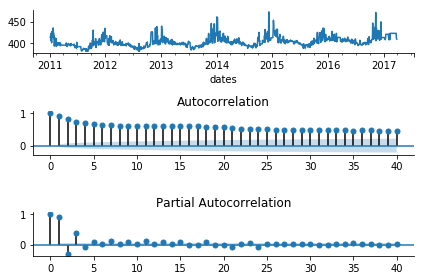

In [38]:
# helper plot for monthly temps
plots(co2, lags=40);

In [40]:
# using itertools to gridsearch solutions
import itertools
import itertools

#set parameter range; UPDATE THESE!
p = q = range(0, 3)
d = range(0, 2)
season = 365

# list of all parameter combos
pdq = list(itertools.product(p, d, q))
# same for seasonal variant
seasonal_pdq = [(x[0], x[1], x[2], season) for x in list(itertools.product(p, d, q))]

print('SARIMAX: {} , {}'.format(pdq[1], seasonal_pdq[1]))
print('SARIMAX: {} , {}'.format(pdq[1], seasonal_pdq[2]))
print('SARIMAX: {} , {}'.format(pdq[2], seasonal_pdq[3]))
print('SARIMAX: {} , {}'.format(pdq[2], seasonal_pdq[4]))

SARIMAX: (0, 0, 1) , (0, 0, 1, 365)
SARIMAX: (0, 0, 1) , (0, 0, 2, 365)
SARIMAX: (0, 0, 2) , (0, 1, 0, 365)
SARIMAX: (0, 0, 2) , (0, 1, 1, 365)


In [ ]:
import warnings
warnings.filterwarnings("ignore") # specify to ignore warning messages
for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            model = sm.tsa.statespace.SARIMAX(co2, order=param,
                        seasonal_order=param_seasonal, enforce_stationarity=False, enforce_invertibility=False).fit()

            print('ARIMA{},{} - AIC:{}'.format(param, param_seasonal, model.aic))
        except:
            continue

ARIMA(0, 0, 0),(0, 0, 1, 365) - AIC:28366.24491044973


### optimize our SARIMAX model using itertools: CAREFUL, this can take a while
warnings.filterwarnings("ignore") # specify to ignore warning messages

for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            model = sm.tsa.statespace.SARIMAX(co2, order=param,
                        seasonal_order=param_seasonal, enforce_stationarity=False, enforce_invertibility=False).fit()

            print('ARIMA{},{} - AIC:{}'.format(param, param_seasonal, model.aic))
        except:
            continue

In [ ]:

import warnings
warnings.filterwarnings("ignore") # specify to ignore warning messages
for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            model = sm.tsa.statespace.SARIMAX(aqi, order=param,
                        seasonal_order=param_seasonal, enforce_stationarity=False, enforce_invertibility=False).fit()

            print('ARIMA{},{} - AIC:{}'.format(param, param_seasonal, model.aic))
        except:
            continue

In [ ]:
#ARIMA(2, 1, 2),(2, 0, 2, 12) - AIC:12042.917228602186

In [76]:
# build model
co2sar = sm.tsa.statespace.SARIMAX(co2, order=(1, 1, 1),
                                seasonal_order=(1, 1, 1, 12),
                                enforce_stationarity=False,
                                enforce_invertibility=False).fit()
co2sar.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 Statespace Model Results                                 
==========================================================================================
Dep. Variable:                            CO2 ppm   No. Observations:                 2274
Model:             SARIMAX(1, 1, 1)x(1, 1, 1, 12)   Log Likelihood               -6236.622
Date:                            Wed, 13 Jun 2018   AIC                          12483.244
Time:                                    20:19:16   BIC                          12511.890
Sample:                                01-06-2011   HQIC                         12493.694
                                     - 03-28-2017                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.2414      0.014    -16.955      0.000      -0.269      -0.213
ma.L1          0.7712      0.010     78.776      0.000       0.752       0.790
ar.S.L12       0.0028      0.000      7.082      0.000       0.002       0.004
ma.S.L12      -0.9842      0.006   -176.513      0.000      -0.995      -0.973
sigma2        14.8467      0.148    100.512      0.000      14.557      15.136
===================================================================================
Ljung-Box (Q):                      291.94   Jarque-Bera (JB):             36592.62
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               0.89   Skew:                            -0.72
Prob(H) (two-sided):                  0.10   Kurtosis:                        22.72
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [ ]:
# create predictions and confidence intervals
pred = co2sar.get_prediction(start=pd.to_datetime('1998-01-01'), dynamic=False) # we use as many true values as possible to predict
pred_ci = pred.conf_int()

In [ ]:
# plot predictions
ax = co2['1993':].plot(label='Observed CO2 Levels')
pred.predicted_mean.plot(ax=ax, label='Forecast', alpha=.8) # this is using all available info

ax.fill_between(pred_ci.index, pred_ci.iloc[:, 0], pred_ci.iloc[:, 1], color='k', alpha=.1)

ax.set_xlabel('Year')
ax.set_ylabel('CO2')
plt.legend()

plt.show();

In [ ]:
# compute mean square error
fcast = pred.predicted_mean
true = co2['1998-01-01':]

mse = ((fcast - true) ** 2).mean()
print('MSE of our forecasts is {}'.format(round(mse, 3)))

In [ ]:
# dynamic forecast
fcast = co2sar.get_prediction(start=pd.to_datetime('1998-01-01'), dynamic=True, full_results=True)
fcast_ci = fcast.conf_int()

# caution: this is modeling assumptions on top of assumptions